# Cell 1
# Required dependencies


In [2]:
!git clone https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch.git
!mkdir data
!mv Facial-Similarity-with-Siamese-Networks-in-Pytorch/data/faces/testing/* data/
!mv Facial-Similarity-with-Siamese-Networks-in-Pytorch/data/faces/training/* data/

!apt install -y libboost-all-dev
!pip install -U pip
!pip install "pybind11[global]"

!pip install aijack

Cloning into 'Facial-Similarity-with-Siamese-Networks-in-Pytorch'...
remote: Enumerating objects: 550, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 550 (delta 6), reused 18 (delta 6), pack-reused 532
Receiving objects: 100% (550/550), 6.32 MiB | 11.71 MiB/s, done.
Resolving deltas: 100% (27/27), done.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libboost-all-dev is already the newest version (1.71.0.0ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-whe

# Cell 2
#Imports

In [3]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

from aijack.attack import MI_FACE
from aijack.defense import GeneralMomentAccountant, DPSGDManager
from aijack.utils import NumpyDataset

BASE = "data/" #Modify to your path
path = "/content/drive/MyDrive/SLPwoapprox_Results/" #Modify

# Cell 3
#Loading data

In [4]:
imgs = []
labels = []
for i in range(1, 41):
    for j in range(1, 8):
        img = cv2.imread(BASE + f"s{i}/{j}.pgm", 0)
        imgs.append(img)
        labels.append(i - 1)

X = np.stack(imgs)
y = np.array(labels)

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
trainset = NumpyDataset(X, y, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True, num_workers=2
)


del X
del y


for i in range(1, 41):
    for j in range(8,11):
        img = cv2.imread(BASE + f"s{i}/{j}.pgm", 0)
        imgs.append(img)
        labels.append(i - 1)

X = np.stack(imgs)
y = np.array(labels)

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
testset = NumpyDataset(X, y, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=4, shuffle=True, num_workers=2
)

# Cell 4
#Creating approximate ReLU function

In [5]:
# simply define a relu approx function
def relu(input):
    return 0.563059 + 0.5*input + 0.078047*input*input#0.119782 + 0.5*out + 0.147298*out*out-0.002015*out*out*out*out

# create a class wrapper from PyTorch nn.Module, so
# the function now can be easily used in models
class ReLu(nn.Module):
    def __init__(self):
        super().__init__() # init the base class

    def forward(self, input):
        return relu(input) # simply apply already implemented relu

# initialize activation function
activation_function = ReLu()

# Cell 5
#Single layer perceptron without approximation

In [6]:
class SLP(nn.Module):
    def __init__(self):
        super(SLP, self).__init__()
        self.fla = nn.Flatten()
        self.fc = nn.Linear(112 * 92, 40)

    def forward(self, x):
        x = self.fla(x)
        x = self.fc(x)
        return x

# Cell 6
#Training SLP

In [7]:
netSLP = SLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(netSLP.parameters(), lr=0.001,momentum=0.9)

for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0
    data_size = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = netSLP(inputs)
        loss = criterion(outputs, labels.to(torch.int64))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        data_size += inputs.shape[0]

    print(f"epoch {epoch}: loss is {running_loss/data_size}")


in_preds = []
in_label = []
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = netSLP(inputs)
        in_preds.append(outputs)
        in_label.append(labels)
    in_preds = torch.cat(in_preds)
    in_label = torch.cat(in_label)
print(
    "Test Accuracy is: ",
    accuracy_score(np.array(torch.argmax(in_preds, axis=1)), np.array(in_label)),
)
     

epoch 0: loss is 0.6317529584680285
epoch 1: loss is 0.11032595458839621
epoch 2: loss is 0.03697129675586309
epoch 3: loss is 0.02136985416124974
epoch 4: loss is 0.015514832309314183
epoch 5: loss is 0.012158652607883727
epoch 6: loss is 0.010208792269362934
epoch 7: loss is 0.008814509765111974
epoch 8: loss is 0.007824864338285156
epoch 9: loss is 0.007000915346933262
epoch 10: loss is 0.006338505709676871
epoch 11: loss is 0.005779392515043062
epoch 12: loss is 0.005332645946847541
epoch 13: loss is 0.004918070200697652
epoch 14: loss is 0.004609393471452806
epoch 15: loss is 0.004318514286673495
epoch 16: loss is 0.004072928751286652
epoch 17: loss is 0.003836265713575163
epoch 18: loss is 0.003647102734872273
epoch 19: loss is 0.003459112615590649
Test Accuracy is:  0.9875


# Cell 7
#Attacking SLP

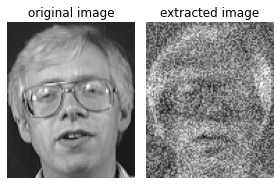

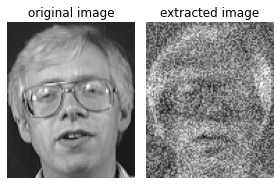

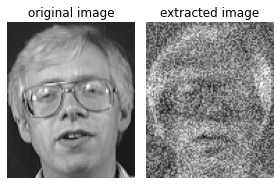

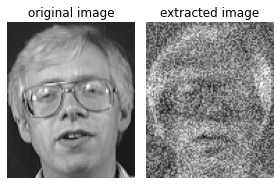

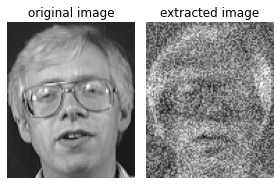

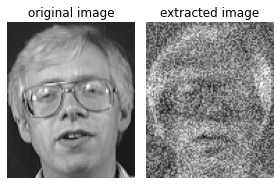

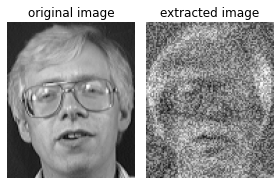

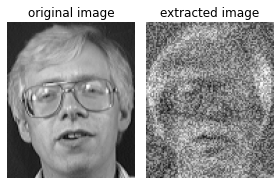

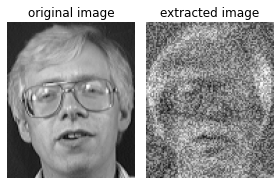

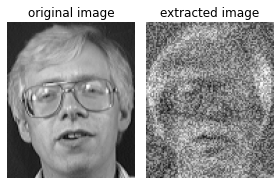

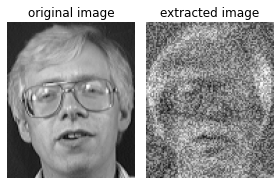

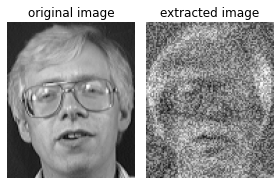

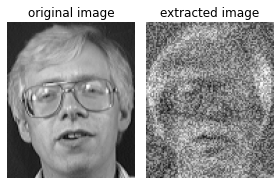

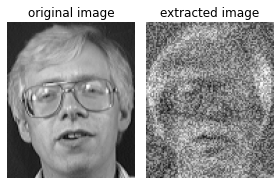

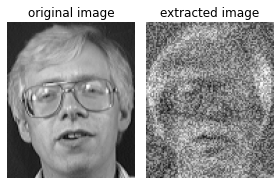

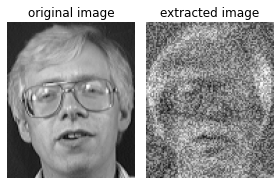

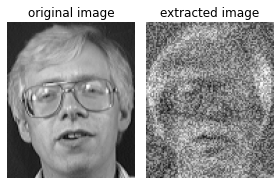

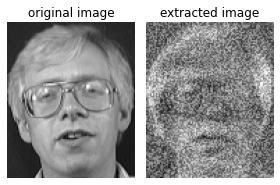

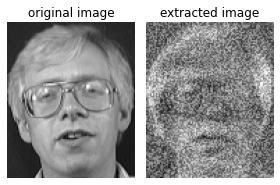

In [ ]:
input_shape = (1, 1, 112, 92)
target_label = 1
lam = 0.1
for num_itr in range(10,200,10):
  mi = MI_FACE(
      netSLP,
      input_shape,
      target_label=target_label,
      num_itr=num_itr,
      lam=lam,
      log_interval=0,
  )
  x_result_1, log = mi.attack()
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4, 3))
  axes[0].imshow(cv2.imread(BASE + "s2/1.pgm", 0), cmap="gray")
  axes[0].axis("off")
  axes[0].set_title("original image")
  axes[1].imshow(x_result_1[0][0].detach().numpy(), cmap="gray")
  axes[1].axis("off")
  axes[1].set_title("extracted image")
  fig.tight_layout()
  name = "SLPwoapprox"+str(num_itr)+".png"
  paths = path+name
  plt.savefig(paths)
  fig.show()
  del mi

<ipython-input-17-f66428eb2a7a>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4, 3))


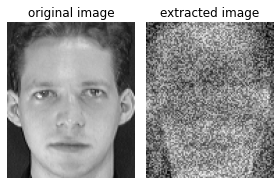

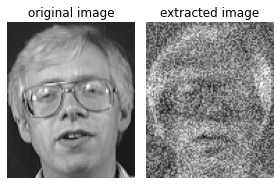

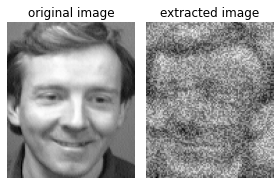

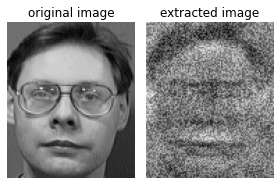

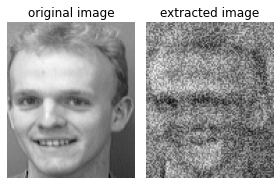

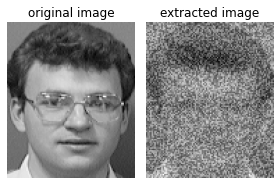

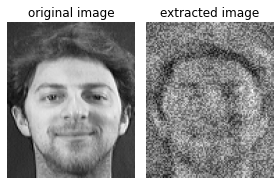

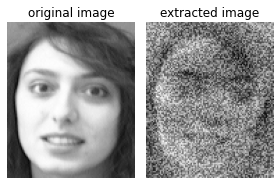

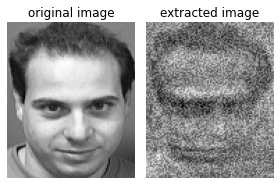

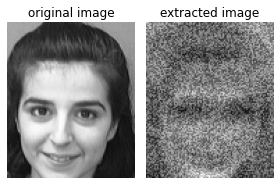

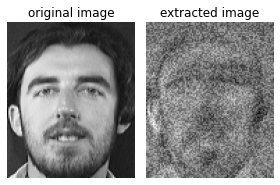

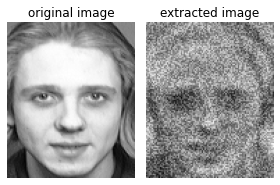

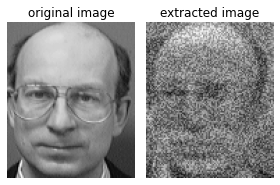

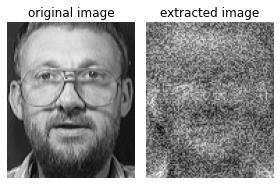

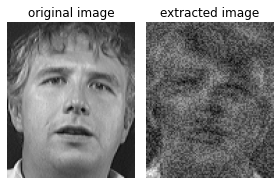

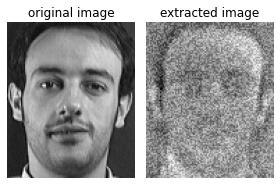

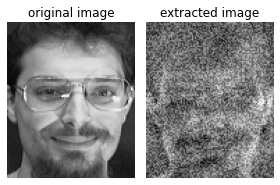

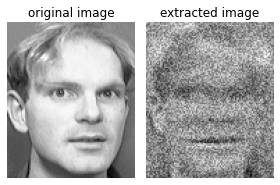

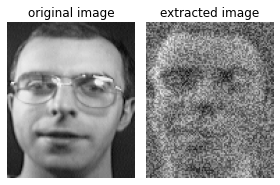

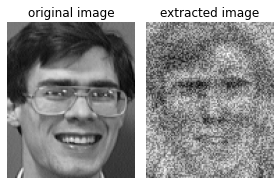

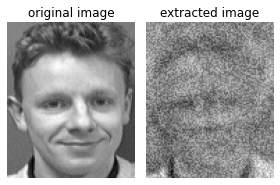

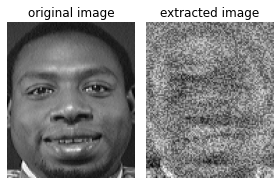

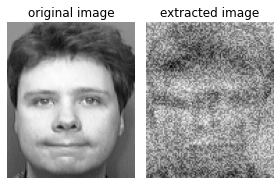

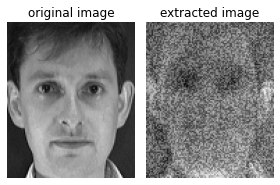

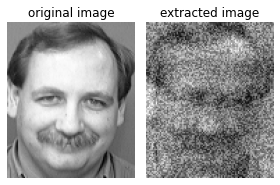

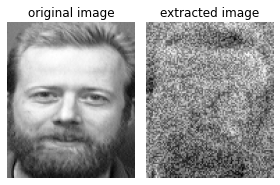

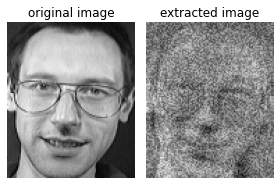

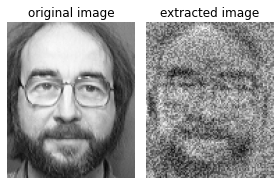

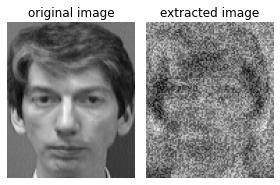

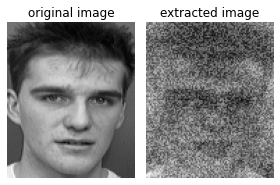

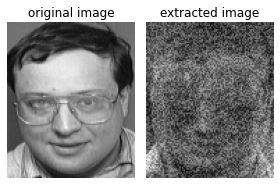

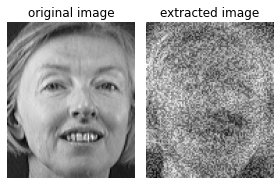

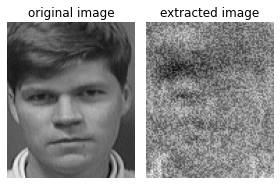

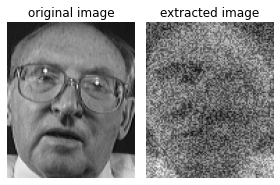

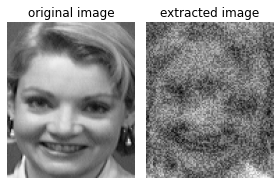

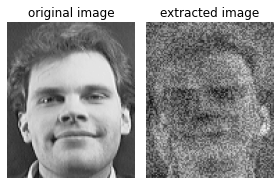

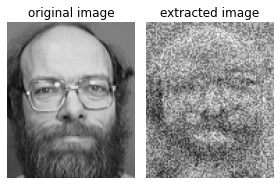

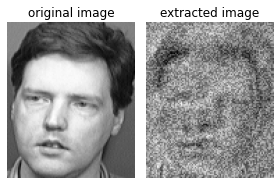

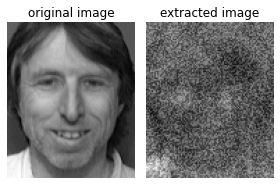

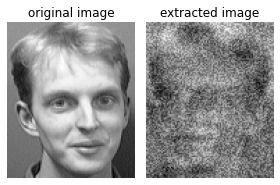

In [ ]:
input_shape = (1, 1, 112, 92)
target_label = 1
lam = 0.1
num_itr = 50
for target_label in range(0,40):
  mi = MI_FACE(
      netSLP,
      input_shape,
      target_label=target_label,
      num_itr=num_itr,
      lam=lam,
      log_interval=0,
  )
  x_result_1, log = mi.attack()
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4, 3))
  originalimage = "s"+str(target_label+1)+"/1.pgm"
  axes[0].imshow(cv2.imread(BASE + originalimage, 0), cmap="gray")
  axes[0].axis("off")
  axes[0].set_title("original image")
  axes[1].imshow(x_result_1[0][0].detach().numpy(), cmap="gray")
  axes[1].axis("off")
  axes[1].set_title("extracted image")
  fig.tight_layout()
  name = "SLPwoapprox"+str(target_label)+".png"
  paths = path+name
  plt.savefig(paths)
  fig.show()
  del mi

# Cell 8
#Applying DPSGD defense

In [ ]:
lot_size = 40
batch_size = 1
iterations = 20
sigma = 0.5
l2_norm_clip = 1
delta = 1e-5

accountant = GeneralMomentAccountant(
    noise_type="Gaussian",
    search="ternary",
    precision=0.001,
    order_max=1,
    order_min=72,
    max_iterations=1000,
    bound_type="rdp_upperbound_closedformula",
    backend="python",
)

privacy_manager = DPSGDManager(
    accountant,
    optim.SGD,
    l2_norm_clip=l2_norm_clip,
    dataset=trainset,
    lot_size=lot_size,
    batch_size=batch_size,
    iterations=iterations,
)
accountant.reset_step_info()
accountant.add_step_info(
    {"sigma": sigma},
    lot_size / len(trainset),
    iterations * (len(trainset) / lot_size),
)
estimated_epsilon = accountant.get_epsilon(delta=delta)
print(f"estimated epsilon is {estimated_epsilon}")

accountant.reset_step_info()
dpoptimizer_cls, lot_loader, batch_loader = privacy_manager.privatize(
    noise_multiplier=sigma
)

estimated epsilon is 56.384900436393984


In [ ]:
net = SLP()
criterion = nn.CrossEntropyLoss()
optimizer = dpoptimizer_cls(net.parameters(), lr=0.05, momentum=0.9)

for epoch in range(iterations):  # loop over the dataset multiple times

    running_loss = 0
    data_size = 0
    preds = []
    labels = []

    for X_lot, y_lot in lot_loader(optimizer):
        for X_batch, y_batch in batch_loader(TensorDataset(X_lot, y_lot)):
            optimizer.zero_grad()
            pred = net(X_batch)
            loss = criterion(pred, y_batch.to(torch.int64))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            data_size += X_batch.shape[0]
            preds.append(pred)
            labels.append(y_batch)

    preds = torch.cat(preds)
    labels = torch.cat(labels)
    print(f"epoch {epoch}: loss is {running_loss/data_size}")

print(f"final epsilon is {accountant.get_epsilon(delta=delta)}")

epoch 0: loss is 3.1190541421120073
epoch 1: loss is 1.5589536211900512
epoch 2: loss is 0.8183916304848777
epoch 3: loss is 0.4064909251097388
epoch 4: loss is 0.23404688448563668
epoch 5: loss is 0.12746415757812304
epoch 6: loss is 0.10971643229622895
epoch 7: loss is 0.06334087157578189
epoch 8: loss is 0.03140084706575415
epoch 9: loss is 0.04154201929881259
epoch 10: loss is 0.02498772646535765
epoch 11: loss is 0.01838149159372029
epoch 12: loss is 0.011136620533617211
epoch 13: loss is 0.012388621930436057
epoch 14: loss is 0.011965269704659656
epoch 15: loss is 0.016898181893017516
epoch 16: loss is 0.01758426644911234
epoch 17: loss is 0.010820548338964507
epoch 18: loss is 0.008841206208739271
epoch 19: loss is 0.006495663791821488
final epsilon is 106.44407633896735


In [ ]:
in_preds = []
in_label = []
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = net(inputs)
        in_preds.append(outputs)
        in_label.append(labels)
    in_preds = torch.cat(in_preds)
    in_label = torch.cat(in_label)
print(
    "Test Accuracy is: ",
    accuracy_score(np.array(torch.argmax(in_preds, axis=1)), np.array(in_label)),
)

Test Accuracy is:  0.935


<ipython-input-21-7504ebf45cf3>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4, 3))


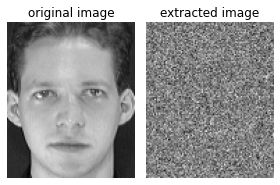

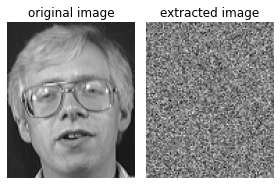

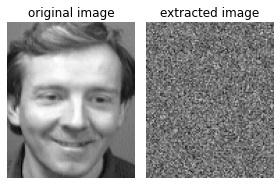

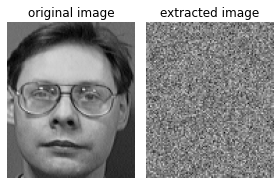

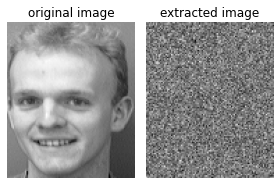

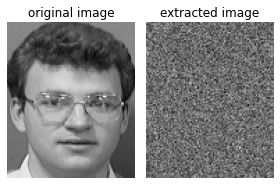

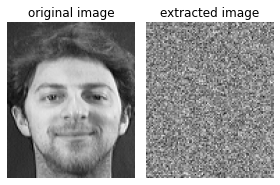

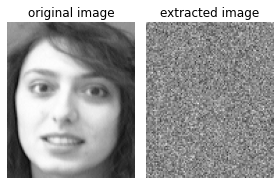

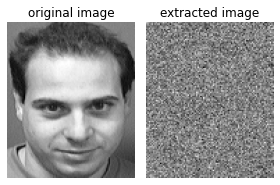

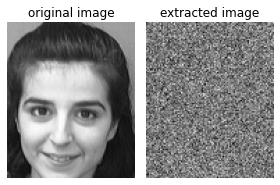

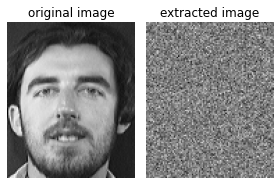

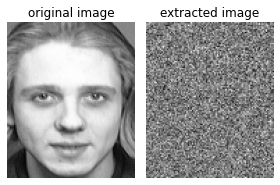

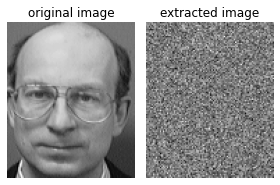

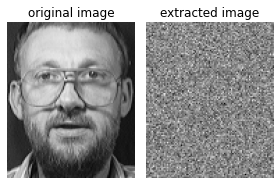

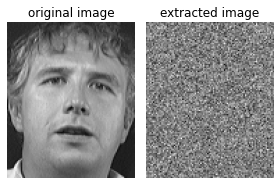

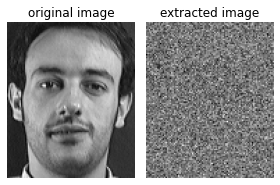

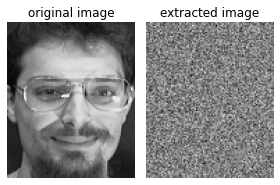

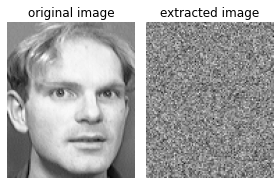

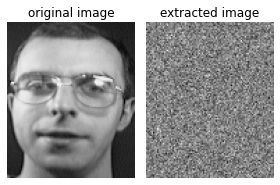

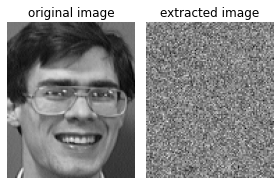

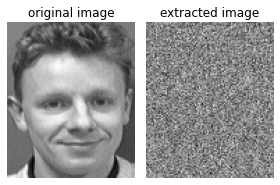

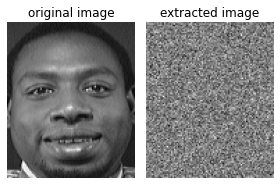

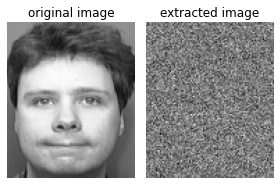

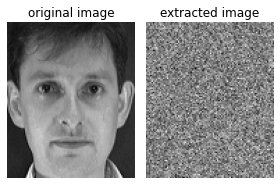

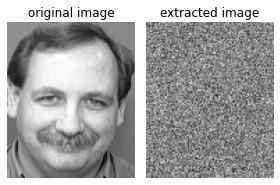

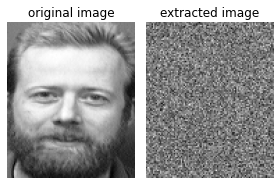

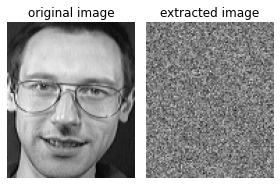

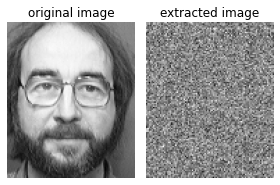

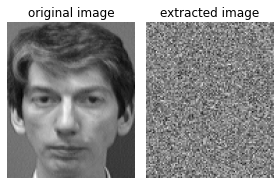

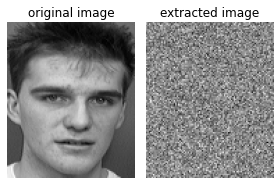

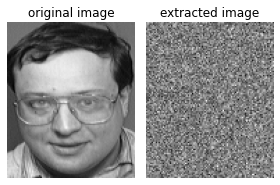

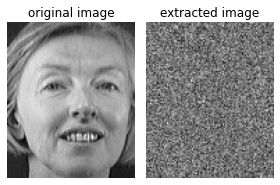

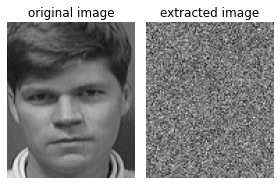

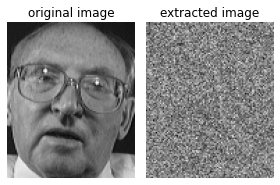

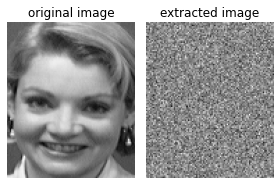

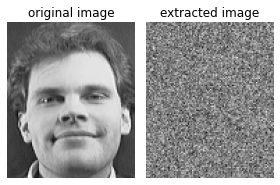

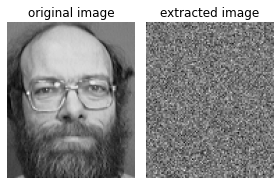

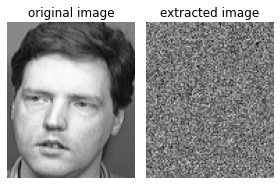

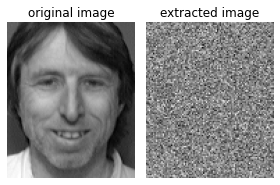

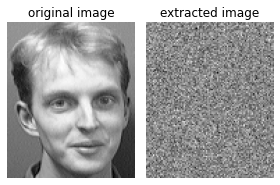

In [ ]:
input_shape = (1, 1, 112, 92)
target_label = 1
lam = 0.1
num_itr = 50
for target_label in range(0,40):
  mi = MI_FACE(
      net,
      input_shape,
      target_label=target_label,
      num_itr=num_itr,
      lam=lam,
      log_interval=0,
  )
  x_result_1, log = mi.attack()
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4, 3))
  originalimage = "s"+str(target_label+1)+"/1.pgm"
  axes[0].imshow(cv2.imread(BASE + originalimage, 0), cmap="gray")
  axes[0].axis("off")
  axes[0].set_title("original image")
  axes[1].imshow(x_result_1[0][0].detach().numpy(), cmap="gray")
  axes[1].axis("off")
  axes[1].set_title("extracted image")
  fig.tight_layout()
  name = "SLP_DPSGD_defense"+str(target_label)+".png"
  paths = path+name
  plt.savefig(paths)
  fig.show()
  del mi